<a href="https://colab.research.google.com/github/EllouziMedAmin/Data-Science/blob/main/sentiment_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/tweet-sentiment-extraction.zip

Archive:  /content/tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!rm /content/tweet-sentiment-extraction.zip

In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import seaborn as sns

In [32]:
twiiter_file='train.csv'
df=pd.read_csv(twiiter_file)

In [33]:
df.shape

(27481, 4)

In [34]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [36]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [37]:
df=df.dropna()

In [38]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [39]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [40]:
cat_id={
    'neutral':1,
    'positive':2,
    'negative':0
}


In [41]:
df['class']=df['sentiment'].map(cat_id)

In [42]:
df

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,2
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,2


In [43]:
#hyperparametre
BATCH_SIZE = 512
NUM_EPOCH=80

In [44]:
from re import X
#separate independent and dependent features
X=df['text'].values
y=df['class'].values

In [45]:
X.shape

(27480,)

In [46]:
y.shape

(27480,)

In [47]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=123)

In [48]:
X_train.shape,y_train.shape

((21984,), (21984,))

In [49]:
X_valid.shape,y_valid.shape

((5496,), (5496,))

In [50]:
one_hot=CountVectorizer()
X_train_one_hot=one_hot.fit_transform(X_train)
X_valid_one_hot=one_hot.transform(X_valid)


In [51]:
#Dataset class
class SentimentData(Dataset):
  def __init__(self,X,y):
    super().__init__()
    self.X=torch.Tensor(X.toarray())
    self.y=torch.Tensor(y).type(torch.LongTensor)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [52]:
train_ds=SentimentData(X_train_one_hot,y_train)
valid_ds=SentimentData(X_valid_one_hot,y_valid)

In [53]:
#dataloader
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(valid_ds,batch_size=15000,shuffle=True)

In [54]:
#model
class SentimentModel(nn.Module):
  def __init__(self,NUM_FEATURES,NUM_CLASSES, HIDDEN=10):
    super().__init__()
    self.linear=nn.Linear(NUM_FEATURES,HIDDEN)
    self.linear2=nn.Linear(HIDDEN,NUM_CLASSES)
    self.relu=nn.ReLU()
    self.log_softmax=nn.LogSoftmax(dim=1)

  def forward(self,x):
    x=self.linear(x)
    x=self.relu(x)
    x=self.linear2(x)
    x=self.log_softmax(x)
    return x

In [55]:
#model , loss and optimizer
model=SentimentModel(NUM_FEATURES=X_train_one_hot.shape[1],NUM_CLASSES=3)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters())

In [56]:
#training

training_losses= []
for e in range(NUM_EPOCH):
  current_loss=0
  for x_batch,y_batch in train_loader:
    optimizer.zero_grad()
    y_pred_log=model(x_batch)
    loss=criterion(y_pred_log,y_batch.long())
    current_loss+=loss.item()
    loss.backward()
    optimizer.step()
  training_losses.append(current_loss)
  print(f"epoch {e} loss {current_loss}")

epoch 0 loss 45.994534492492676
epoch 1 loss 43.01017987728119
epoch 2 loss 39.148033142089844
epoch 3 loss 35.1189079284668
epoch 4 loss 31.458818078041077
epoch 5 loss 28.35389268398285
epoch 6 loss 25.73855769634247
epoch 7 loss 23.53000283241272
epoch 8 loss 21.62942811846733
epoch 9 loss 20.018944054841995
epoch 10 loss 18.604686230421066
epoch 11 loss 17.368209093809128
epoch 12 loss 16.271450608968735
epoch 13 loss 15.292621493339539
epoch 14 loss 14.433284133672714
epoch 15 loss 13.642964988946915
epoch 16 loss 12.942951500415802
epoch 17 loss 12.292348727583885
epoch 18 loss 11.703260853886604
epoch 19 loss 11.174364298582077
epoch 20 loss 10.686028629541397
epoch 21 loss 10.238811418414116
epoch 22 loss 9.817831069231033
epoch 23 loss 9.43998372554779
epoch 24 loss 9.075587838888168
epoch 25 loss 8.75127600133419
epoch 26 loss 8.441231489181519
epoch 27 loss 8.146098360419273
epoch 28 loss 7.8818874061107635
epoch 29 loss 7.638202428817749
epoch 30 loss 7.3937544375658035
epo

<Axes: >

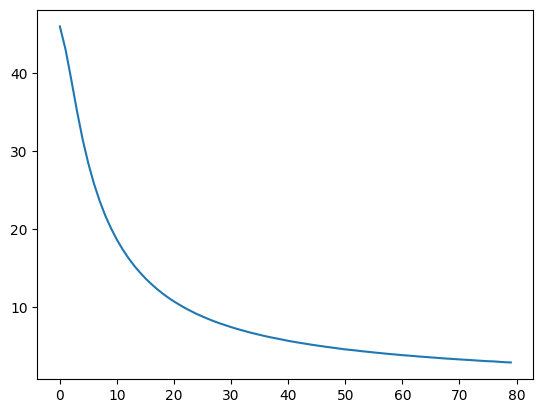

In [58]:
sns.lineplot(x=list(range(len(training_losses))),y=training_losses)

In [59]:
with torch.no_grad():
  for x_batch,y_batch in valid_loader:
    y_valid_pred_log=model(x_batch)
    y_valid_pred=torch.argmax(y_valid_pred_log,dim=1)


In [60]:
y_valid_pred_np=y_valid_pred.squeeze().cpu().numpy()

In [61]:
accuray=accuracy_score(y_pred=y_valid_pred_np,y_true=y_valid)
f"The accuracy of the model is {np.round(accuray,3)*100}%"

'The accuracy of the model is 34.599999999999994'

In [62]:
most_common_cnt=Counter(y_valid).most_common()[0][1]
f"Naive classifier : {np.round(most_common_cnt/len(y_valid)*100,1)}%"

'Naive classifier : 40.0%'

<Axes: >

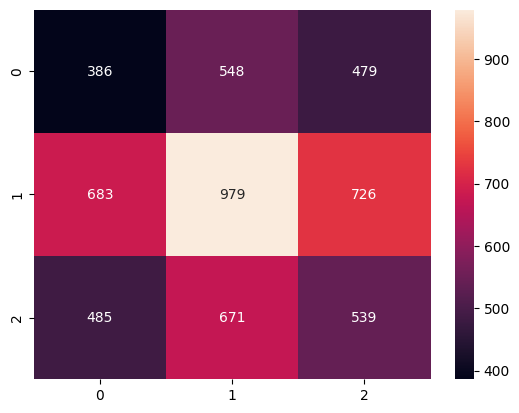

In [64]:
sns.heatmap(confusion_matrix(y_valid_pred_np,y_valid),annot=True,fmt=".0f")